In [2]:
import torch
import torch.nn as nn
from torch.autograd import grad

from sklearn.datasets import fetch_20newsgroups

import gensim

from collections import Counter

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

# from tensorboardX import SummaryWriter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# writer = SummaryWriter()

# Load and preprocess data

In [76]:
# Load documents
documents = fetch_20newsgroups(subset='train', remove=('headers', 'footers',  'quotes'), shuffle=True)

# Preprocess with gensim and remove stopwords
documents = [[word for word in gensim.utils.simple_preprocess(document) if not word in gensim.parsing.preprocessing.STOPWORDS]
             for document in documents['data'][:1000]]

# Remove rare words by applying a frequency threshold
freq_threshold = 1
counts = Counter([word for document in documents for word in document])

documents = [list(filter(lambda word : counts[word] > freq_threshold, document)) for document in documents]
documents = list(filter(lambda document : len(document) > 0, documents))

# Map words to integer indices
counts = Counter([word for document in documents for word in document])

word_idx_dict = {word : i for i, word in enumerate(counts.keys())}
idx_word_dict = {i : word for word, i in word_idx_dict.items()}

documents = [torch.tensor(list(map(lambda word : word_idx_dict[word], document))) for document in documents]

In [77]:
class VariationalLDA(nn.Module):
    
    def __init__(self, documents, vocab_size, num_topics, log_eta, log_alpha):
        
        super(VariationalLDA, self).__init__()
        
        self.D = len(documents)
        self.K = num_topics
        self.V = vocab_size
        
        self.words = documents
        
        k_ones = torch.ones(size=(self.K,)).to(device)
        
        self.log_eta = nn.Parameter(torch.tensor(log_eta).to(device))
        self.log_alpha = nn.Parameter((log_alpha * k_ones + torch.rand(self.K).to(device)).to(device))
        
        self.gamma = [torch.exp(log_alpha * k_ones) + k_ones * len(Counter(document)) / self.K
                      for document in documents]
        
        self.phi = [torch.ones(size=(document.shape[0], self.K)).to(device) / self.K
                    for document in documents]
        
        self.lamda = torch.ones(size=(self.K, self.V)).to(device)
    
    
    def elbo(self):
        
        self.eta = torch.exp(self.log_eta)
        self.alpha = torch.exp(self.log_alpha)
        
        elbo = 0
        
        eta_vector = self.eta * torch.ones(self.V).to(device)
        
        lamda_digamma_diff = self.digamma_difference(self.lamda)
        gamma_digamma_diff = [self.digamma_difference(gamma_d) for gamma_d in self.gamma]
        
        eta_log_gamma_diff = self.log_gamma_difference(eta_vector)
        alpha_log_gamma_diff = self.log_gamma_difference(self.alpha)
        gamma_log_gamma_diff = [self.log_gamma_difference(gamma_d) for gamma_d in self.gamma]
        lamda_log_gamma_diff = self.log_gamma_difference(self.lamda)
        
        elbo = elbo + sum([torch.einsum('nk, kn ->', phi_d, lamda_digamma_diff[:, words_d])
                           for phi_d, words_d in zip(self.phi, self.words)])
        
        elbo = elbo + sum([torch.einsum('nk, k ->', phi_d, gamma_digamma_diff_d)
                           for phi_d, gamma_digamma_diff_d in zip(self.phi, gamma_digamma_diff)])
        
        elbo = elbo + self.D * alpha_log_gamma_diff
        
        elbo = elbo + sum([torch.einsum('k, k ->', self.alpha - 1, gamma_digamma_diff_d)
                           for gamma_digamma_diff_d in gamma_digamma_diff])
        
        elbo = elbo + self.K * eta_log_gamma_diff
        
        elbo = elbo + torch.einsum('v, kv ->', eta_vector - 1, lamda_digamma_diff)
        
        elbo = elbo - sum([torch.sum(phi_d * torch.log(phi_d)) for phi_d in self.phi])
        
        elbo = elbo - sum(gamma_log_gamma_diff)
        
        elbo = elbo - sum([torch.einsum('k, k ->', gamma_d - 1, gamma_digamma_diff_d)
                           for gamma_d, gamma_digamma_diff_d in zip(self.gamma, gamma_digamma_diff)])
        
        elbo = elbo - torch.sum(lamda_log_gamma_diff)
        
        elbo = elbo - torch.einsum('kv, kv ->', self.lamda - 1, lamda_digamma_diff)
        
        return elbo
    
    
    def forward(self):
        return - self.elbo()
    
    
    def variational_parameter_step(self):
        
        self.eta = torch.exp(self.log_eta.detach())
        self.alpha = torch.exp(self.log_alpha.detach())
        
        # Update gamma
        self.gamma = [(self.alpha + torch.sum(phi_d, dim=0)) for phi_d in self.phi]
        
        # Update lamda
        self.lamda = torch.ones((self.K, self.V)).to(device) * self.eta
        k_range = torch.arange(self.K)
        
        for d in range(self.D):
            for n in range(self.words[d].shape[0]):
                self.lamda[:, self.words[d][n]] += self.phi[d][n]
        
        # Update phi
        digamma_lamda = self.digamma_difference(self.lamda)
        words_digamma_lamda = [digamma_lamda[:, self.words[d]].T for d in range(self.D)]
        
        digamma_gamma = [torch.digamma(self.gamma[d]) - \
                         torch.digamma(torch.sum(self.gamma[d], dim=-1)[..., None]) for d in range(self.D)]
        
        self.phi = [torch.exp(words_digamma_lamda[d] + digamma_gamma[d]) for d in range(self.D)]
        self.phi = [phi_d / torch.sum(phi_d, dim=-1)[..., None] for phi_d in self.phi]
    
    
    def model_parameter_step(self):
        pass
    
    
    def perplexity(self):
        pass
    
    
    def digamma_difference(self, tensor):
        return torch.digamma(tensor) - torch.digamma(torch.sum(tensor, dim=-1)[..., None])
    
    
    def log_gamma_difference(self, tensor):
        return torch.lgamma(torch.sum(tensor, dim=-1)) - torch.sum(torch.lgamma(tensor), dim=-1)

In [78]:
lda = VariationalLDA(documents, len(counts), num_topics=20, log_eta=-1., log_alpha=-1.)

In [79]:
num_em_iters = 5
num_e_steps, print_every_e = 10, 1
num_m_steps, print_every_m = 50, 1
verbose = False

elbos = []

optimizer = torch.optim.SGD(lda.parameters(), lr=1e-5)

for i in tqdm(range(num_em_iters)):
    
    for j in tqdm(range(num_m_steps), leave=False):

        lda.variational_parameter_step()
    
        if j % print_every_m == 0 and verbose:
            print(lda.gamma[0].cpu().detach().numpy())
            
        elbos.append(lda.elbo())
            
    for j in tqdm(range(num_e_steps), leave=False):

        if j % print_every_e == 0 and verbose:
            print(torch.exp(lda.log_eta).cpu().detach().numpy())
            print(torch.exp(lda.log_alpha).cpu().detach().numpy())

        optimizer.zero_grad()

        neg_elbo = - lda.elbo()

        neg_elbo.backward()

        optimizer.step()
        
        elbos.append(lda.elbo())

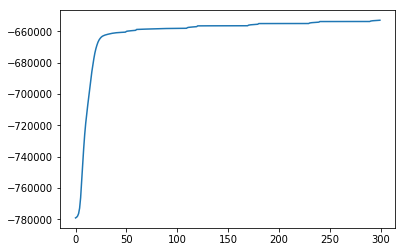

In [80]:
plt.plot(elbos)
plt.show()

<BarContainer object of 100 artists>

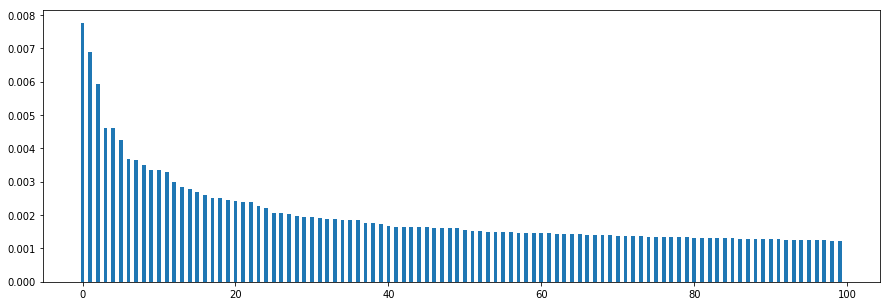

In [93]:
topic_idx = 10
plt.figure(figsize=(15, 5))
beta, beta_idx = torch.sort(torch.distributions.dirichlet.Dirichlet(lda.lamda[topic_idx]).rsample(), descending=True)
y = beta.detach().cpu().numpy()[:100]
x = torch.arange(len(y))
plt.bar(x, y, width=0.5)

In [94]:
for idx in beta_idx:
    
    print(idx_word_dict[int(idx)])

nasa
weaver
space
cooper
mission
pilot
coptic
shuttle
astronaut
desirable
applicants
program
station
requirements
people
harris
fadeley
government
dr
civilian
psychology
selection
continued
spence
trial
applications
council
science
howen
accredited
president
military
cross
lodge
candidates
flight
kevin
johnson
stated
apparent
said
redesign
update
churches
day
application
texas
ktvb
mr
degree
events
specialist
specific
perform
university
played
agent
astronauts
center
job
ayoub
conducted
trying
randy
class
wealth
equipment
defense
judge
attorney
duty
payload
similar
technology
following
annually
statesman_
selected
detailed
note
degrees
review
experience
named
mean
tapes
spokane
physical
pay
assist
case
office
earth
specialists
better
fair
speaking
ev
experts
vest
recommendations
pick
inches
win
image
weapon
federal
time
dollars
astro
apply
provides
assigned
planning
tribute
candidate
information
reports
colors
atf
college
remote
seriously
date
plans
april
foolish
agencies
houston
remem

trading
q_
growing
varied
committed
lockheed
times_
preface
cl
identified
easier
st
device
brief
citizenship
xlookupstring
chipset
team
vel
los
hal
lamb
doug
sabotage
rl
managers
corner
behave
kp
winning
panel
cxp
lou
nagorno
drew
indiana
violated
accordingly
ann
motors
skepticism
dangerous
njd
pf
offered
reserved
cordially
million
harmful
conceive
evildoers
fallacy
jjb
bitterly
pto
bears
gaspra
reveal
strike
martial
stanford
ah
encrypted
pallone
funky
misc
esa
contacted
assisted
census
homosexuals
citizenry
told
falsehood
wisconsin
rkba
tampa
compromise
separated
motion
approach
gagner
debugger
ot
appeal
crimes
positioning
tall
placebo
discuss
unconscious
pull
consequences
jupiter
friends
scholar
higher
assertion
eliminating
aware
ijh
recording
decimal
went
regards
okz
battery
foods
animals
reliability
acm
ruuttu
excluding
fd
observing
bother
dro
gyro
mustang
suspicion
hobby
alt
eu
equivalently
realize
acs
ctl
profit
come
ccw
drug
failing
burning
excluded
cpu
range
community
passed
cw

audi
procession
angel
tender
pursuing
heresy
christi
programmers
english
tooltalk
turks
hole
updated
properly
girl
subject
order
existed
anger
odgers
liquid
titan
disclaimer
aix
implemented
balls
daughters
morris
dynamic
saint
filioque
extensions
asala
sees
march
belfour
pmf
minority
terminals
coastlands
tactical
constitutional
blow
vincent
sinful
connected
school
reaction
feel
prophecies
phrase
bl
exhaustive
eliminated
adresses
nervous
wh
smith
zy
absolutes
electricity
lidstrom
establish
et
conclusion
suits
graphics
apples
jericho
cyrus
holik
execution
digital
reflects
glue
religions
wait
participating
designers
colorview
wilson
genius
window
substantially
clutter
sx
reject
donated
hga
economical
presume
deadline
maltais
initiated
mitsubishi
validly
australian
bedford
muslims
epistemology
blatantly
molesters
dle
tartar
shown
lightweight
mb
smokeless
social
twice
gg
divmhm
height_field
heghinian
jap
improvement
meat
deer
ik
primer
sensible
leach
stone
waited
anecdotal
standings
hidden


crystal
strain
tie
isn
beginning
yamada
forgot
omitted
basically
reviews
send
komotini
vendors
initialized
emerson
knock
homosexuality
structural
facilities
subjective
bat
rsc
cellular
willing
ass
meaning
mess
treats
fetishes
ruff
qt
cocaine
ironically
bands
reasons
bound
judas
decisions
died
sweet
defend
qr
fanatic
smarmy
podiatric
assembler
drink
ought
saturday
break
waters
combo
ijf
passage
subset
winter
repugnant
gph
performance
proponents
beer
relays
diminishing
steiner
stages
ottoman
asuacad
second
interpret
brink
bigger
environmental
native
unspeakable
fiction
invoke
ncr
jumbo
declare
stadium
survaillance
shepherd
backyard
diarrhea
massacres
occasion
woodlice
stop
ye
uhd
evason
unlike
agdam
uci
cruising
traded
ulx
undefined
characterize
probe
sunset
pleased
weddings
passion
xi
remotely
americans
church
chicago
stimulate
shaped
keeps
points
idiotic
mack
sq
daniel
destroy
aca
analogy
arena
verification
provider
mvmhi
corrected
deficit
morphology
chip
rocks
saints
site
gonzalez
see

occur
iml
plantation
parity
metaphor
snip
jsc
burrows
obviously
ou
immanuel
farther
sep
secretary
av
oi
deliver
subdivide_tri
greece
bogus
rpm
bis
sucked
vlb
dom
inflicted
accusation
jan
pages
wiretap
zip
ef
diseases
windows
forsale
save
sheet
connector
grayscale
vis
song
coating
athletic
true
pem
anal
times
ogrodnick
cooperation
watt
uh
hollins
sighted
hoc
aleksandr
separating
protesting
serial
situs
respect
nixon
flybys
bmp
ocs
viewpoint
heading
qb
hampered
inside
material
rewrites
weep
throne
cb
ft
blindness
senate
conditions
fanatics
lynch
aim
nhs
ranks
bargain
northern
fun
lawn
lu
conjecture
navarro
utexas
platoon
ends
inerrant
allergic
stalingrad
differences
ramsey
trigger
ltq
klinger
hp
typewriter
resupply
oriented
cops
prediction
administrative
complain
yeah
happens
rings
suffering
origen
ecf
assure
dodgers
yc
anytime
percentage
baden
town
griffin
xview
parents
algorithm
wick
nambla
axes
panic
spot
quickly
anonymous
persecutions
substantial
lock
identical
berryhill
zx
nevada
cr